In [1]:
import scanpy as sc
import scipy
from scipy.sparse import issparse
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import gc
import re
import psutil
from typing import Optional, Tuple, Dict, Any
import logging

# configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
# load male and female adata and aggregate
adata_corrected_female = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_female_2025.h5ad')
adata_corrected_male = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_male_2025.h5ad')

In [ ]:
adata_corrected_male

In [ ]:
adata_corrected_female

In [ ]:
same_set = set(adata_corrected_female.var_names) == set(adata_corrected_male.var_names)
print("Same gene set?", same_set)
print("A genes:", adata_corrected_female.n_vars, "B genes:", adata_corrected_male.n_vars)

#### Concat the two pools and name their batches

In [ ]:
for adx in (adata_corrected_female, adata_corrected_male):
    adx.var_names = adx.var_names.astype(str)
    adx.var_names_make_unique()

In [ ]:
adata_cellbender_combined = ad.concat(
    {"male": adata_corrected_male, "female": adata_corrected_female},
    axis=0,
    join="inner",         # use "outer" if you want union of genes (missing filled with 0)
    label="batch",
    index_unique=None     # keep original cell barcodes (ensure they won't collide)
)

In [ ]:
adata_cellbender_combined

In [ ]:
adata_cellbender_combined.obs['batch'].value_counts()

In [ ]:
def remove_duplicates(adata, axis='obs', strategy='first'):
    """
    Remove barcode duplicates with different strategies
    
    Parameters:
    - axis: 'obs' for cells, 'var' for genes
    - strategy: 'first', 'last', 'highest_counts' (for obs only)
    """
    if axis == 'obs':
        index = adata.obs.index
        if strategy == 'first':
            keep_mask = ~index.duplicated(keep='first')
        elif strategy == 'last':
            keep_mask = ~index.duplicated(keep='last')
        elif strategy == 'highest_counts':
            # Keep the cell with highest UMI counts among duplicates
            keep_indices = []
            for name in index.unique():
                name_mask = index == name
                if name_mask.sum() > 1:  # If duplicated
                    if 'nCount_RNA' in adata.obs.columns:
                        best_idx = adata.obs.loc[name_mask, 'nCount_RNA'].idxmax()
                        keep_indices.extend([i for i, idx in enumerate(adata.obs.index) if idx == best_idx])
                    else:
                        # Fall back to first if no count info
                        keep_indices.append(np.where(name_mask)[0][0])
                else:
                    keep_indices.extend(np.where(name_mask)[0])
            keep_mask = np.zeros(adata.n_obs, dtype=bool)
            keep_mask[keep_indices] = True
        
        return adata[keep_mask].copy()
    
    else:  # axis == 'var'
        index = adata.var.index
        if strategy == 'first':
            keep_mask = ~index.duplicated(keep='first')
        elif strategy == 'last':
            keep_mask = ~index.duplicated(keep='last')
        else:
            keep_mask = ~index.duplicated(keep='first')  # Default to first
        
        return adata[:, keep_mask].copy()

In [ ]:
print("\n=== Removing Duplicates ===")
original_shape = adata_cellbender_combined.shape
# Remove cell duplicates (keeping first occurrence)
adata_subset = remove_duplicates(adata_cellbender_combined, axis='obs', strategy='first')

In [ ]:
dup_mask = adata_subset.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_subset.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_subset.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

In [ ]:
adata_subset

In [ ]:
# save the combined adata
adata_subset.write_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_aggr_2025_dedup.h5ad')

## Combine the two adatas

In [ ]:
# load datasets
adata_corrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_aggr_2025_dedup.h5ad')
adata_uncorrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/ERCC1_KO_mice_aggr_updated.h5ad')

In [ ]:
adata_uncorrected.obs

In [ ]:
# Use regex to replace any suffix _2 through _8 with _1
adata_uncorrected.obs.index = adata_uncorrected.obs.index.str.replace(r'-[2-8]$', '-1', regex=True)

In [ ]:
# check of cell ranger uncorrected data has duplicates
dup_mask = adata_uncorrected.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_uncorrected.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_uncorrected.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

In [ ]:
print("\n=== Removing Duplicates ===")
original_shape = adata_uncorrected.shape
# Remove cell duplicates (keeping first occurrence)
adata_uncorrected = remove_duplicates(adata_uncorrected, axis='obs', strategy='first')

In [ ]:
# check of cell ranger uncorrected data has duplicates
dup_mask = adata_uncorrected.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_uncorrected.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_uncorrected.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

In [ ]:
# find overlapping cells
common_cells = adata_uncorrected.obs.index.intersection(adata_corrected.obs.index)
common_genes = adata_uncorrected.var.index.intersection(adata_corrected.var.index)
print(f"Found {len(common_cells)} common cells")
print(f"Found {len(common_genes)} common genes")

In [ ]:
adata_orig_subset = adata_uncorrected[common_cells, common_genes].copy()
adata_corrected_subset = adata_corrected[common_cells, common_genes].copy()

In [ ]:
# copy over all processed data
adata_combined = adata_orig_subset.copy()

In [ ]:
# add cellbender counts as layer
adata_combined.layers['cellbender'] = adata_corrected_subset.X.copy()

In [ ]:
print("Transferring cell metadata (obs)...")
for col in adata_corrected_subset.obs.columns:
    if col not in adata_combined.obs.columns:
        # Initialize new column with appropriate dtype
        if adata_corrected_subset.obs[col].dtype == 'object':
            adata_combined.obs[col] = pd.NA
        else:
            adata_combined.obs[col] = np.nan
    
    # Update values for common cells
    adata_combined.obs[col] = adata_corrected_subset.obs[col]

In [ ]:
adata_combined.obs

In [ ]:
# Transfer obsm with logging
print(f"Transferring {len(adata_corrected_subset.obsm.keys())} obsm entries:")
for key in adata_corrected_subset.obsm.keys():
    print(f"  - {key}: {adata_corrected_subset.obsm[key].shape}")
    adata_combined.obsm[key] = adata_corrected_subset.obsm[key].copy()

# Transfer varm with logging
print(f"Transferring {len(adata_corrected_subset.varm.keys())} varm entries:")
for key in adata_corrected_subset.varm.keys():
    print(f"  - {key}: {adata_corrected_subset.varm[key].shape}")
    adata_combined.varm[key] = adata_corrected_subset.varm[key].copy()

# Transfer uns with logging
print(f"Transferring {len(adata_corrected_subset.uns.keys())} uns entries:")
for key in adata_corrected_subset.uns.keys():
    print(f"  - {key}")
    adata_combined.uns[key] = adata_corrected_subset.uns[key]

In [ ]:
adata_combined

## Compare performance of correcting counts matrix

In [2]:
infile = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/query_combined.h5ad'

In [ ]:
adata_combined.X = adata_combined.layers['cellbender']

In [ ]:
# add the vars you need to get per-gene metrics on (for corrected counts add new var columns)
adata_combined.var['mt_cb'] = adata_combined.var_names.str.startswith('mt-')
adata_combined.var['ribo_cb'] = adata_combined.var_names.str.startswith(('rps', 'rpl'))
adata_combined.var["hb_cb"] = adata_combined.var_names.str.contains("^hb[^(p)]")

sc.pp.calculate_qc_metrics(
    adata_combined, qc_vars=["mt_cb", "ribo_cb", "hb_cb"], inplace=True, percent_top=[20], log1p=True
)
adata_combined

### Filter cells based on QC thresholds

In [ ]:
# cut of cells to compare cellbender vs uncorrected counts on the same scale
adata_combined = adata_combined[adata_combined.obs['total_counts_mt_cb'] < 300]
adata_combined = adata_combined[adata_combined.obs['total_counts_mt'] < 300]

In [ ]:
sc.pl.violin(
    adata_combined,
    ["total_counts_mt", "total_counts_mt_cb"],
    groupby='sample_id',
    jitter=0.4,
    multi_panel=True,
    rotation=90
)

In [ ]:
# cell bender probability of being cell and not soup
adata_combined = adata_combined[adata_combined.obs['cell_probability'] > 0.8]
# remove the barcodes that are predicted to be doublets
adata_combined = adata_combined[adata_combined.obs['predicted_doublet'] == False]

## Normalisation and dim reduction

In [20]:
adata = sc.read_h5ad(infile)

In [21]:
adata

AnnData object with n_obs × n_vars = 60965 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb'
    uns: 'log1p', 's

In [22]:
# get the number of F and M cells from sex obs
adata.obs['sex'].value_counts()

sex
M    34262
F    26703
Name: count, dtype: int64

In [23]:
adata.X = adata.layers['cellbender']
print(adata.X.min())
print(adata.X.max())
print(adata.X.mean())


0
5509
0.07496193944684586


#### Pre-proc for scran normalization

In [ ]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
adata_pp.X = adata_pp.layers['cellbender']
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

#### Pre-proc for log1p and hvg 

In [7]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False, layer='cellbender')
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

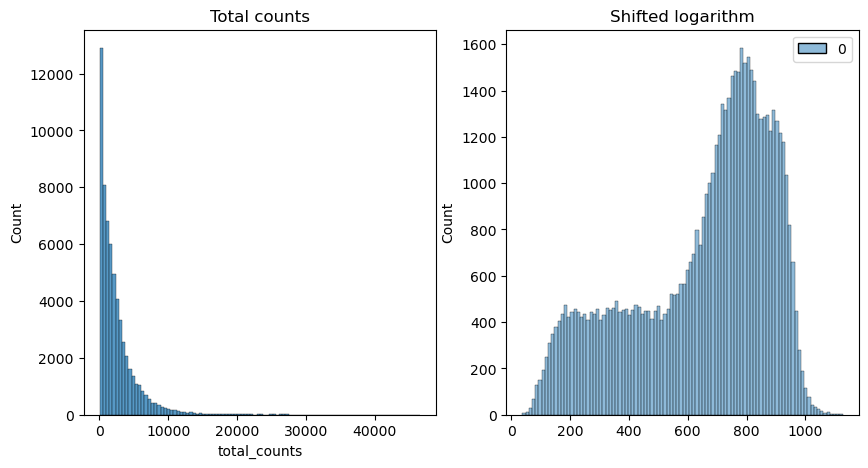

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [51]:
adata.X = adata.layers['log1p_norm']

In [52]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key="sample_id")

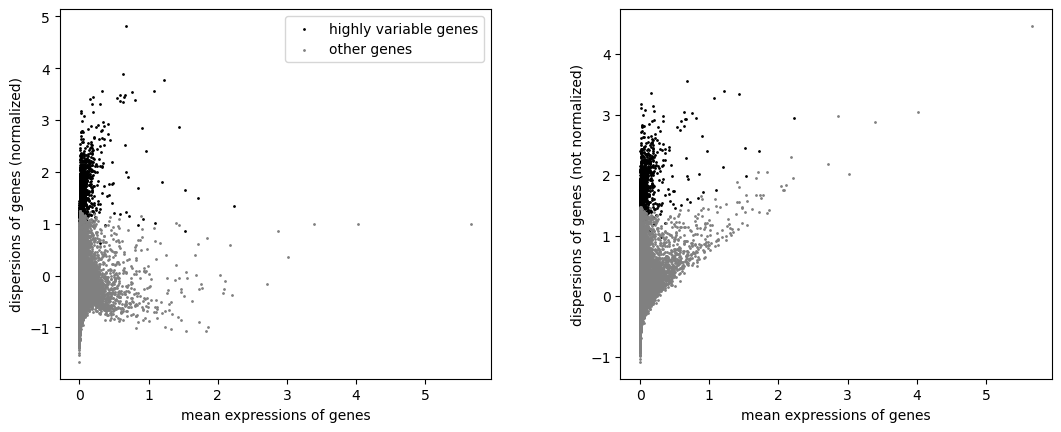

In [53]:
sc.pl.highly_variable_genes(adata)

In [54]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


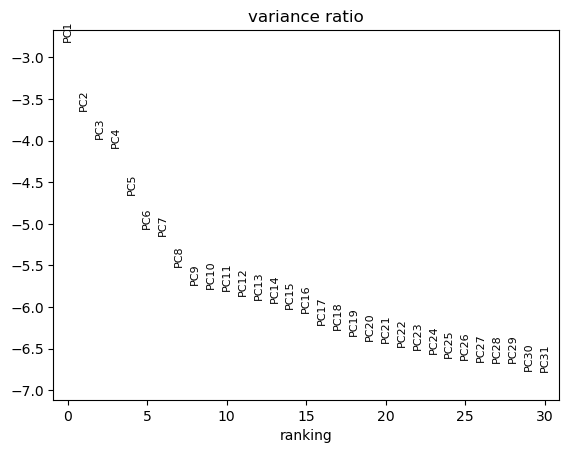

In [55]:
sc.pl.pca_variance_ratio(adata, n_pcs=30, log=True)

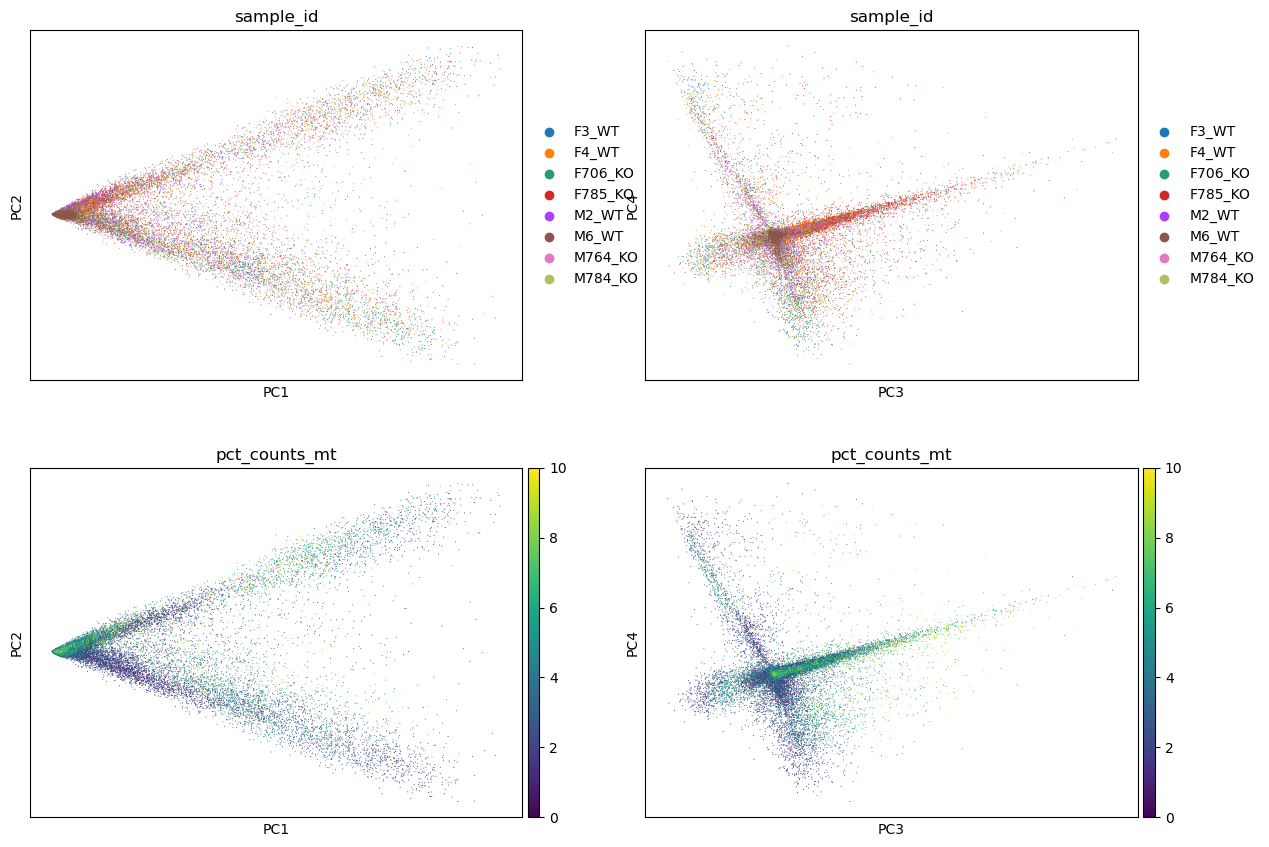

In [56]:
sc.pl.pca(
    adata,
    color=["sample_id", "sample_id", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [58]:
adata

AnnData object with n_obs × n_vars = 60965 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb', 'highly_variable', 

## Harmony correction for batch effect between sexes

In [61]:
sc.external.pp.harmony_integrate(
    adata,
    key='sex',
    basis='X_pca',
    adjusted_basis='X_pca_harmony',
    theta=[0.8],                     # Conservative - preserves biology
    sigma=0.06,                      # Precise - targets technical effects
    max_iter_harmony=6,              # Limited iterations
    plot_convergence=True,           # Monitor progress
    verbose=True,
    random_state=42
)

2025-09-10 22:43:18,149 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-09-10 22:43:27,954 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-09-10 22:43:28,304 - harmonypy - INFO - Iteration 1 of 6
INFO:harmonypy:Iteration 1 of 6
2025-09-10 22:43:44,998 - harmonypy - INFO - Iteration 2 of 6
INFO:harmonypy:Iteration 2 of 6
2025-09-10 22:44:01,680 - harmonypy - INFO - Iteration 3 of 6
INFO:harmonypy:Iteration 3 of 6
2025-09-10 22:44:18,357 - harmonypy - INFO - Iteration 4 of 6
INFO:harmonypy:Iteration 4 of 6
2025-09-10 22:44:34,967 - harmonypy - INFO - Iteration 5 of 6
INFO:harmonypy:Iteration 5 of 6
2025-09-10 22:44:45,350 - harmonypy - INFO - Iteration 6 of 6
INFO:harmonypy:Iteration 6 of 6
2025-09-10 22:44:54,088 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


In [62]:
adata

AnnData object with n_obs × n_vars = 60965 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb', 'highly_variable', 

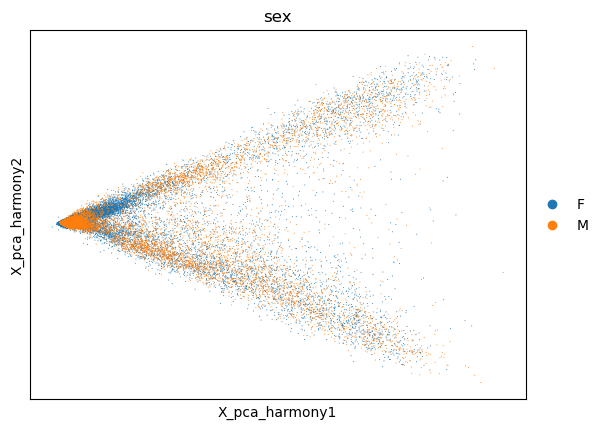

In [63]:
sc.pl.embedding(adata, 'X_pca_harmony', color=['sex'])

In [65]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(adata)

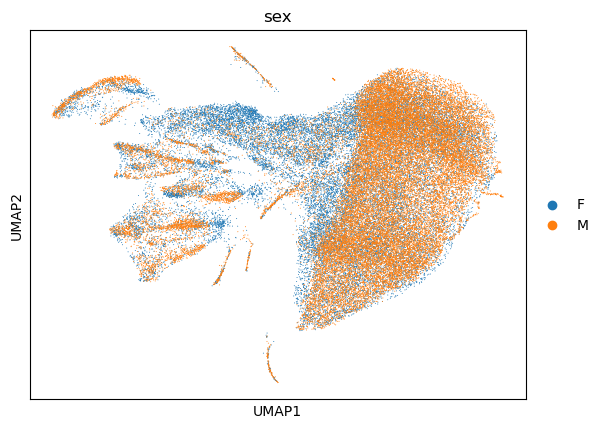

In [66]:
sc.pl.umap(adata, color=['sex'])

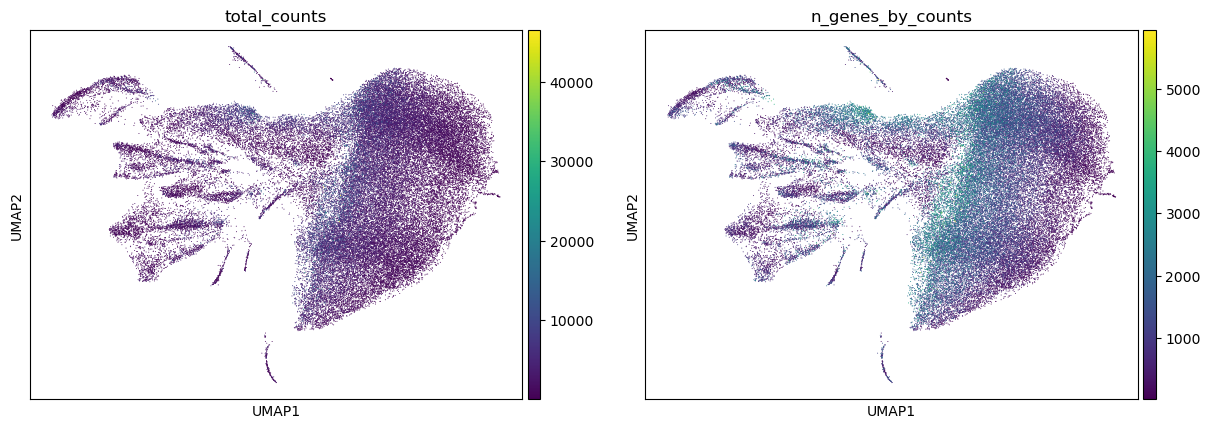

In [67]:
sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts'])